#https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2013
##The variable dictionary to understand the code at the top of each column. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed

import re
import sklearn

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
from pandas.io.json import json_normalize 
data = pd.read_csv('/Users/Sandi/Desktop/Projects/Capstone_2/questionnaire.csv')
demographics = pd.read_csv('/Users/Sandi/Desktop/Projects/Capstone_2/demographic.csv')
labs = pd.read_csv('/Users/Sandi/Desktop/Projects/Capstone_2/labs.csv')

**Data Set Merge and Select Attribute**

In [4]:
data.drop(['SEQN'], axis = 1, inplace=True)
demographics.drop(['SEQN'], axis = 1, inplace=True)
labs.drop(['SEQN'], axis = 1, inplace=True)
#https://www.kaggle.com/what0919/diabetes-prediction

In [5]:
df = pd.concat([data, demographics], axis=1, join='inner')
df = pd.concat([df, labs], axis=1, join='inner')
df.describe()
#merge

,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ101,ALQ110,ALQ120Q,ALQ120U,ALQ130,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
count,5548.0,16.0,166.0,2292.000000,975.000000,5223.000000,1576.000000,4312.000000,3460.000000,3463.000000,...,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,2664.000000,1261.000000,2662.000000,5316.000000,5316.000000
mean,1.0,8.0,9.0,3.109075,2.949744,1.312464,1.595812,4.787801,1.924566,3.534796,...,0.186950,0.007883,0.150535,0.162162,0.012038,0.177177,1.969072,15.670639,640.100263,472.394865
std,0.0,0.0,0.0,1.513612,1.731617,0.548327,0.619028,35.079943,0.854441,29.410605,...,0.133833,0.088452,0.576409,0.368669,0.034026,0.381890,0.251651,46.735936,751.967084,554.951537
min,1.0,8.0,9.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.013000,0.000000,0.013000,0.000000,0.001400,0.000000,1.000000,0.280000,18.000000,13.300000
25%,1.0,8.0,9.0,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.090000,0.000000,0.028000,0.000000,0.002600,0.000000,2.000000,3.210000,381.000000,281.200000
50%,1.0,8.0,9.0,3.000000,3.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,0.159000,0.000000,0.069000,0.000000,0.005100,0.000000,2.000000,6.240000,514.000000,379.300000
75%,1.0,8.0,9.0,4.000000,5.000000,2.000000,2.000000,4.000000,3.000000,3.000000,...,0.252000,0.000000,0.150000,0.000000,0.010700,0.000000,2.000000,12.435000,711.000000,524.700000
max,1.0,8.0,9.0,9.000000,5.000000,9.000000,9.000000,999.000000,3.000000,999.000000,...,1.290000,1.000000,25.760000,1.000000,0.843400,1.000000,3.000000,1071.300000,26801.000000,19779.100000


**NaN Handling and Feature Column Selection**

In [6]:
from sklearn.feature_selection import VarianceThreshold

df = df.rename(columns = {'SEQN' : 'ID',
                          'RIAGENDR' : 'Gender',
                          'WHD120' : 'WeightAt25Yrs', 
                          'WHD130' : 'HeightAt25Yrs',
                          'LBXPLTSI' : 'PlateletCount',
                          'LBXSCK' : 'CreatinePhosphokinase',
                          'MCQ160A' : 'HasArthritis',
                          'MCQ010' : 'HasAsthma',
                          'CSQ204' : 'AllergyCongestionPast12Months',
                          'DBQ010' : 'Breast_fed',
                          'DBQ229' : 'UseMilk>=5x/wk',
                          'DBQ235B' : 'DrankMilkAge13to17yrs',
                          'DBQ235C' : 'DrankMilkAge18to35yrs',
                          'PUQ100' : 'ChemicalPesticideUsedInHomePast7days',
                          'PUQ110' : 'ChemicalWeedKillUsedExteriorHomePast7days',
                          'PAQ677' : 'Past7DaysCardio20Minutes+',
                          'PAQ678' : 'Past7DaysStrengthTone20Minutes+',
                          'PAQ706' : 'Past7DaysCardio60Minutes+'})

df = df.loc[:, ['ID', 'Gender', 'WeightAt25Yrs', 'HeightAt25Yrs','PlateletCount', 'CreatinePhosphokinase', 
                'HasArthritis', 'HasAsthma', 'AllergyCongestionPast12Months', 'Breast_fed', 'UseMilk>=5x/wk', 
                'DrankMilkAge13to17yrs', 'DrankMilkAge18to35yrs', 'ChemicalPesticideUsedInHomePast7days', 'ChemicalWeedKillUsedExteriorHomePast7days',
                'Past7DaysCardio20Minutes+', 'Past7DaysStrengthTone20Minutes+', 'Past7DaysCardio60Minutes+']]



**Feature Generation**
new column should be created for BMI.  
#The formula is BMI = kg/m2 where kg is a person’s weight in kilograms and m2 is their height in meters squared.
'WeightAt25Yrs' in kg divided by the 'HeightAt25Yrs' in meters squared.  

In [7]:
df.insert(4, 'BMI', df['WeightAt25Yrs']/ (df['WeightAt25Yrs']**2), True)
#need to check the units for weight and height.
#https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/WHQ_H.htm#Component_Description
#English Instructions:
    #ENTER HEIGHT IN FEET AND INCHES OR METERS AND CENTIMETERS.
    #RECORD CURRENT WEIGHT. ENTER WEIGHT IN POUNDS OR KILOGRAMS. 
    #IF PREGNANT, ASK FOR WEIGHT BEFORE PREGNANCY. 

In [8]:
df.dropna(axis=1, how='all')
df.dropna(axis=0, how='all')
df.head(10)

,ID,Gender,WeightAt25Yrs,HeightAt25Yrs,BMI,PlateletCount,CreatinePhosphokinase,HasArthritis,HasAsthma,AllergyCongestionPast12Months,Breast_fed,UseMilk>=5x/wk,DrankMilkAge13to17yrs,DrankMilkAge18to35yrs,ChemicalPesticideUsedInHomePast7days,ChemicalWeedKillUsedExteriorHomePast7days,Past7DaysCardio20Minutes+,Past7DaysStrengthTone20Minutes+,Past7DaysCardio60Minutes+
0,NaN,1,200.0,69.0,0.005000,204.0,174.0,1.0,2.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN
1,NaN,1,250.0,72.0,0.004000,314.0,147.0,2.0,1.0,2.0,NaN,1.0,3.0,3.0,2.0,2.0,NaN,NaN,NaN
2,NaN,1,190.0,70.0,0.005263,237.0,44.0,2.0,2.0,2.0,NaN,1.0,3.0,3.0,1.0,2.0,NaN,NaN,NaN
3,NaN,1,NaN,NaN,NaN,240.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,5.0
4,NaN,2,135.0,67.0,0.007407,300.0,60.0,1.0,2.0,2.0,NaN,1.0,3.0,3.0,2.0,2.0,NaN,NaN,NaN
5,NaN,1,195.0,64.0,0.005128,249.0,340.0,1.0,2.0,2.0,NaN,3.0,3.0,3.0,1.0,2.0,NaN,NaN,NaN
6,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,2,127.0,64.0,0.007874,180.0,120.0,1.0,1.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN
8,NaN,1,185.0,NaN,0.005405,296.0,90.0,2.0,2.0,2.0,NaN,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN
9,NaN,2,120.0,61.0,0.008333,187.0,220.0,1.0,2.0,2.0,NaN,1.0,3.0,3.0,2.0,2.0,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Data columns (total 19 columns):
ID                                           0 non-null float64
Gender                                       9813 non-null int64
WeightAt25Yrs                                4842 non-null float64
HeightAt25Yrs                                2667 non-null float64
BMI                                          4842 non-null float64
PlateletCount                                8544 non-null float64
CreatinePhosphokinase                        6542 non-null float64
HasArthritis                                 5561 non-null float64
HasAsthma                                    9422 non-null float64
AllergyCongestionPast12Months                3680 non-null float64
Breast_fed                                   1803 non-null float64
UseMilk>=5x/wk                               5561 non-null float64
DrankMilkAge13to17yrs                        4126 non-null float64
DrankMilkAge18to35yrs      

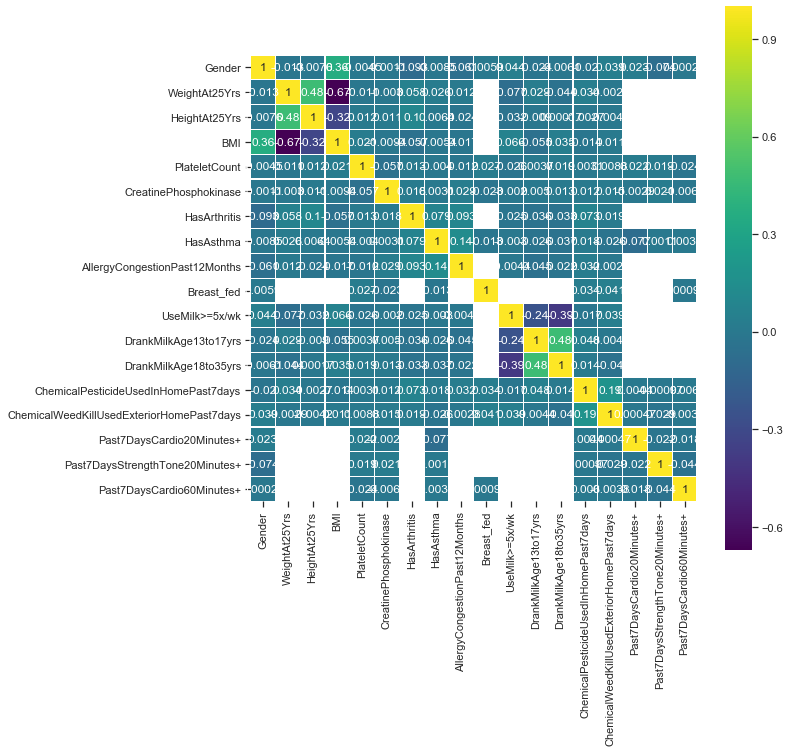

In [47]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(df.astype(float).drop(axis=1, labels='ID').corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

In [10]:
df['Past7DaysCardio20Minutes+'].value_counts()

5.0     149
3.0     107
0.0     106
2.0      77
4.0      64
1.0      59
7.0      50
6.0      42
99.0      1
Name: Past7DaysCardio20Minutes+, dtype: int64

In [11]:
df['Past7DaysStrengthTone20Minutes+'].value_counts()

0.0    195
2.0    108
3.0    101
1.0     96
5.0     75
4.0     38
7.0     29
6.0     13
Name: Past7DaysStrengthTone20Minutes+, dtype: int64

In [12]:
df['Past7DaysCardio60Minutes+'].value_counts()

7.0     1730
5.0      311
3.0      188
4.0      173
2.0      154
0.0      128
6.0      109
1.0       86
99.0       8
Name: Past7DaysCardio60Minutes+, dtype: int64

**Exercise conversion to be counted at yes if indicated 3 or more days that week**

In [13]:
#old value(string) into new value(integer)  #1 == "yes"
df.loc[(df['Past7DaysCardio20Minutes+'] >=3) & (df['Past7DaysCardio20Minutes+'] <=7),'Past7DaysCardio20Minutes+'] = 1

In [14]:
df.loc[(df['Past7DaysStrengthTone20Minutes+'] >=3) & (df['Past7DaysStrengthTone20Minutes+'] <=7),'Past7DaysStrengthTone20Minutes+'] = 1

In [15]:
df.loc[(df['Past7DaysCardio60Minutes+'] >=3) & (df['Past7DaysCardio60Minutes+'] <=7),'Past7DaysCardio60Minutes+'] = 1

In [16]:
df['Past7DaysCardio20Minutes+'].value_counts()
#those marked as 1.0 did the activity three or more days in the week

1.0     471
0.0     106
2.0      77
99.0      1
Name: Past7DaysCardio20Minutes+, dtype: int64

In [17]:
df['Past7DaysStrengthTone20Minutes+'].value_counts()
#those marked as 1.0 did the activity three or more days in the week

1.0    352
0.0    195
2.0    108
Name: Past7DaysStrengthTone20Minutes+, dtype: int64

In [18]:
df['Past7DaysCardio60Minutes+'].value_counts()
#those marked as 1.0 did the activity three or more days in the week

1.0     2597
2.0      154
0.0      128
99.0       8
Name: Past7DaysCardio60Minutes+, dtype: int64

In [19]:
#https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/MCQ_H.htm#MCQ160a
df['HasArthritis'].value_counts()
#those marked as 1.0 said yes that a doctor or health pro told them they had arthritis

2.0    4093
1.0    1455
9.0      13
Name: HasArthritis, dtype: int64

**Question:  Is there a correlation with those who reported having been told they had arthritis, and their blood counts?**
When arthritis = 1.0, report the Creatine Phosphokinase.  
In general, high CPK levels in the muscle suggest the presence of inflammatory muscle disease, but they can also be caused by trauma, injection into the muscle, or muscle disease due to hypothyroidism. Conversely, low levels of CPK can be indicative of rheumatoid arthritis.
https://www.arthritis-health.com/glossary/creatine-phosphokinase

In [28]:
arthritis_bc = df.loc[(df['HasArthritis'] == 1), ['CreatinePhosphokinase', 'PlateletCount']]

In [34]:
arthritis_bc
#What to do with Nan values?
#dropna

,CreatinePhosphokinase,PlateletCount
0,174.0,204.0
4,60.0,300.0
5,340.0,249.0
7,120.0,180.0
9,220.0,187.0
50,NaN,221.0
56,88.0,243.0
58,NaN,294.0
59,67.0,196.0
61,NaN,370.0


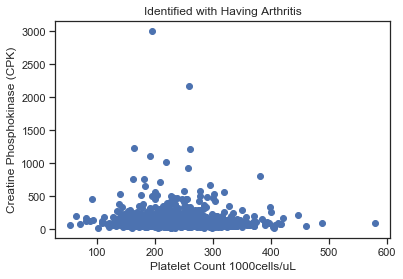

In [71]:
_ = plt.scatter(arthritis_bc['PlateletCount'], arthritis_bc['CreatinePhosphokinase'])

_ = plt.xlabel('Platelet Count 1000cells/uL')
_ = plt.ylabel('Creatine Phosphokinase (CPK)')
_ = plt.title('Identified with Having Arthritis')                

##**Then to look at those who have been identified as having asthma, connecting to their answers for the milk, being breast-fed, chemical pesticide use, BMI at age 25, 'Past7DaysCardio20Minutes+', 'Past7DaysStrengthTone20Minutes+', 'Past7DaysCardio60Minutes+'.**
clustering analysis, machine learning predicting.  Will give groups.  Pick one group, plot.





##**Look at the BMI at age 25.  Does that correlate with any of the three exercise columns? 'Past7DaysCardio20Minutes+', 'Past7DaysStrengthTone20Minutes+', 'Past7DaysCardio60Minutes+'**

##**Then to look at those who have been identified as having allergycongestion, connecting to their answers for the milk, being breast-fed, chemical pesticide use.**